In [173]:
import pandas as pd
import numpy as np
import seaborn as sns
import chardet
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

In [174]:
#Настроим отображение всех столбцов

pd.set_option('display.max_columns', None)

In [175]:
#Определим какой декодер использовать при открытии файла

file = r'C:\Users\aksen\PycharmProjects\pythonProject\data\property_info.csv'

with open(file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'windows-1251', 'confidence': 0.99, 'language': 'Russian'}

In [176]:
#Загружаем дадасет

df = pd.read_csv(file, encoding='windows-1251')
df

,price,rooms,full_area,living_area,kitchen_area,floor_number,floors_in_building,repair_type,bathroom_type,material_type,year_build,flat_type,balcony_type
0,3300000.0,1.0,30.0,18.0,6.0,3.0,5.0,в хорошем состоянии,совмещенный,панель,1974.0,вторичное,"балкон, остекление"
1,8500000.0,2.0,58.7,NaN,NaN,6.0,19.0,в отличном состоянии,раздельный,кирпич,2020.0,вторичное,балкон
2,2000000.0,1.0,13.0,NaN,NaN,1.0,5.0,NaN,совмещенный,панель,1980.0,вторичное,NaN
3,8100000.0,2.0,63.5,31.8,9.4,3.0,10.0,в хорошем состоянии,совмещенный,кирпич,2007.0,вторичное,"балкон и лоджия, остекление"
4,6600000.0,2.0,60.0,35.0,25.0,NaN,NaN,в отличном состоянии,совмещенный,кирпич,1963.0,вторичное,"балкон, остекление"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5211,2100000.0,2.0,27.0,24.0,NaN,6.0,9.0,в отличном состоянии,NaN,кирпич,1988.0,вторичное,NaN
5212,1600000.0,2.0,37.7,NaN,NaN,5.0,5.0,в хорошем состоянии,совмещенный,панель,NaN,вторичное,балкон
5213,570000.0,3.0,64.0,NaN,NaN,1.0,1.0,требуется ремонт,NaN,дерево,NaN,вторичное,NaN
5214,4850000.0,3.0,58.0,41.0,5.0,5.0,5.0,в хорошем состоянии,раздельный,панель,1972.0,вторичное,балкон


In [177]:
#Исследуем данные

print(f'В исходном датасете {df.shape[0]} строк и {df.shape[1]} столбцов')

В исходном датасете 5216 строк и 13 столбцов


In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               5216 non-null   float64
 1   rooms               5213 non-null   float64
 2   full_area           5213 non-null   float64
 3   living_area         1799 non-null   float64
 4   kitchen_area        2959 non-null   float64
 5   floor_number        4701 non-null   float64
 6   floors_in_building  4701 non-null   float64
 7   repair_type         4700 non-null   object 
 8   bathroom_type       4739 non-null   object 
 9   material_type       5158 non-null   object 
 10  year_build          4418 non-null   float64
 11  flat_type           5213 non-null   object 
 12  balcony_type        3639 non-null   object 
dtypes: float64(8), object(5)
memory usage: 529.9+ KB


In [179]:
#Пропущенные значения

for column in df.columns:
    print(f'Пропуски в колонке {column} составляют {round(df[column].isna().sum()/df.shape[0]*100,2)} %')

Пропуски в колонке price составляют 0.0 %
Пропуски в колонке rooms составляют 0.06 %
Пропуски в колонке full_area составляют 0.06 %
Пропуски в колонке living_area составляют 65.51 %
Пропуски в колонке kitchen_area составляют 43.27 %
Пропуски в колонке floor_number составляют 9.87 %
Пропуски в колонке floors_in_building составляют 9.87 %
Пропуски в колонке repair_type составляют 9.89 %
Пропуски в колонке bathroom_type составляют 9.14 %
Пропуски в колонке material_type составляют 1.11 %
Пропуски в колонке year_build составляют 15.3 %
Пропуски в колонке flat_type составляют 0.06 %
Пропуски в колонке balcony_type составляют 30.23 %


In [180]:
#Нулевые значения с категориальных признаках заменим на unknown
df[[
 'repair_type',
 'bathroom_type',
 'material_type',
 'flat_type',
 'balcony_type']] = df[[
 'repair_type',
 'bathroom_type',
 'material_type',
 'flat_type',
 'balcony_type']].fillna('unknown')

In [181]:
#Делаем копию датасета с пропущенными численными признаками. Заполняем пропущенные значения с KNNInputer
df_2 = df[[
    'rooms',
 'full_area',
 'living_area',
 'kitchen_area',
'floor_number',
 'floors_in_building']]
imputer = KNNImputer(n_neighbors=3, weights='distance')
new_df = imputer.fit_transform(df_2)

In [182]:
new_df = pd.DataFrame(new_df)

new_df[4] = round(new_df[4])
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       5216 non-null   float64
 1   1       5216 non-null   float64
 2   2       5216 non-null   float64
 3   3       5216 non-null   float64
 4   4       5216 non-null   float64
 5   5       5216 non-null   float64
dtypes: float64(6)
memory usage: 244.6 KB


In [183]:
dataset = pd.concat((df[['price', 'repair_type','bathroom_type','material_type','flat_type','balcony_type', 'year_build']], new_df), axis=1)
dataset = dataset.rename(columns={0:'rooms', 1:'full_area', 2:'living_area', 3:'kitchen_area', 4:'floor_number', 5:'floors_in_building'})
dataset['year_build'] = dataset['year_build'].fillna(-1)

In [188]:
#Добавим новые фичи: стоимость кв.м. жилья и возраст жилья

def price_metr(x, y):
    return round(x/y)
def age(x):
    if x != -1:
        return datetime.now().year-x
    else:
        return -1

dataset['price_square_metr'] = dataset.apply(lambda x: price_metr(x['price'], x['full_area']), axis=1)
dataset['age'] = dataset['year_build'].apply(age)
dataset

,price,repair_type,bathroom_type,material_type,flat_type,balcony_type,year_build,rooms,full_area,living_area,kitchen_area,floor_number,floors_in_building,price_square_metr,age
0,3300000.0,в хорошем состоянии,совмещенный,панель,вторичное,"балкон, остекление",1974.0,1.0,30.0,18.000000,6.000000,3.0,5.0,110000,49.0
1,8500000.0,в отличном состоянии,раздельный,кирпич,вторичное,балкон,2020.0,2.0,58.7,49.940000,11.261538,6.0,19.0,144804,3.0
2,2000000.0,unknown,совмещенный,панель,вторичное,unknown,1980.0,1.0,13.0,11.500000,4.000000,1.0,5.0,153846,43.0
3,8100000.0,в хорошем состоянии,совмещенный,кирпич,вторичное,"балкон и лоджия, остекление",2007.0,2.0,63.5,31.800000,9.400000,3.0,10.0,127559,16.0
4,6600000.0,в отличном состоянии,совмещенный,кирпич,вторичное,"балкон, остекление",1963.0,2.0,60.0,35.000000,25.000000,6.0,9.0,110000,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5211,2100000.0,в отличном состоянии,unknown,кирпич,вторичное,unknown,1988.0,2.0,27.0,24.000000,6.729942,6.0,9.0,77778,35.0
5212,1600000.0,в хорошем состоянии,совмещенный,панель,вторичное,балкон,-1.0,2.0,37.7,25.375146,5.000000,5.0,5.0,42440,-1.0
5213,570000.0,требуется ремонт,unknown,дерево,вторичное,unknown,-1.0,3.0,64.0,43.216667,14.000000,1.0,1.0,8906,-1.0
5214,4850000.0,в хорошем состоянии,раздельный,панель,вторичное,балкон,1972.0,3.0,58.0,41.000000,5.000000,5.0,5.0,83621,51.0


In [189]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               5216 non-null   float64
 1   repair_type         5216 non-null   object 
 2   bathroom_type       5216 non-null   object 
 3   material_type       5216 non-null   object 
 4   flat_type           5216 non-null   object 
 5   balcony_type        5216 non-null   object 
 6   year_build          5216 non-null   float64
 7   rooms               5216 non-null   float64
 8   full_area           5216 non-null   float64
 9   living_area         5216 non-null   float64
 10  kitchen_area        5216 non-null   float64
 11  floor_number        5216 non-null   float64
 12  floors_in_building  5216 non-null   float64
 13  price_square_metr   5216 non-null   int64  
 14  age                 5216 non-null   float64
dtypes: float64(9), int64(1), object(5)
memory usage: 611.4+

In [190]:
dataset.describe()

,price,year_build,rooms,full_area,living_area,kitchen_area,floor_number,floors_in_building,price_square_metr,age
count,5.216000e+03,5216.000000,5216.000000,5216.000000,5216.000000,5216.000000,5216.000000,5216.000000,5216.000000,5216.000000
mean,5.520044e+06,1686.044862,2.002686,51.948454,34.123912,8.866025,4.513229,8.102297,105658.040069,27.148773
std,3.801396e+06,717.377158,0.946707,27.972034,20.080499,4.934989,3.484828,4.470360,29665.900133,24.389963
min,0.000000e+00,-1.000000,1.000000,9.000000,4.000000,1.000000,1.000000,1.000000,0.000000,-1.000000
25%,3.500000e+06,1966.000000,1.000000,34.800000,19.000000,6.000000,2.000000,5.000000,89021.000000,6.000000
50%,4.800000e+06,1984.000000,2.000000,48.580000,30.800000,8.000000,4.000000,7.000000,104775.000000,23.000000
75%,6.500000e+06,2010.000000,3.000000,63.625000,43.000000,10.180455,6.000000,10.000000,121639.000000,47.000000
max,6.000000e+07,2023.000000,7.000000,320.000000,220.900000,70.900000,26.000000,26.000000,289062.000000,163.000000


In [191]:
#Удалим строки с 0 прайсом, так как это целевая метрика для прогнозирования
row_list = dataset[dataset['price']==0].index.tolist()
dataset = dataset.drop(index=row_list)

In [192]:
dataset.corr()

C:\Users\aksen\AppData\Local\Temp\ipykernel_23264\2191645083.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset.corr()


,price,year_build,rooms,full_area,living_area,kitchen_area,floor_number,floors_in_building,price_square_metr,age
price,1.000000,-0.022117,0.603778,0.849701,0.781840,0.570517,0.122189,0.177706,0.478544,-0.297391
year_build,-0.022117,1.000000,-0.017977,-0.072174,-0.087915,-0.092088,0.008896,0.021185,0.104271,0.463866
rooms,0.603778,-0.017977,1.000000,0.803229,0.761535,0.409097,0.004406,-0.007215,-0.125149,-0.041608
full_area,0.849701,-0.072174,0.803229,1.000000,0.918179,0.628875,0.084596,0.109460,0.037831,-0.247096
living_area,0.781840,-0.087915,0.761535,0.918179,1.000000,0.543166,0.059575,0.067904,0.033148,-0.208599
kitchen_area,0.570517,-0.092088,0.409097,0.628875,0.543166,1.000000,0.110161,0.139794,0.092107,-0.304951
floor_number,0.122189,0.008896,0.004406,0.084596,0.059575,0.110161,1.000000,0.635887,0.149192,-0.269326
floors_in_building,0.177706,0.021185,-0.007215,0.109460,0.067904,0.139794,0.635887,1.000000,0.258782,-0.442677
price_square_metr,0.478544,0.104271,-0.125149,0.037831,0.033148,0.092107,0.149192,0.258782,1.000000,-0.217537
age,-0.297391,0.463866,-0.041608,-0.247096,-0.208599,-0.304951,-0.269326,-0.442677,-0.217537,1.000000


<Axes: xlabel='price', ylabel='rooms'>

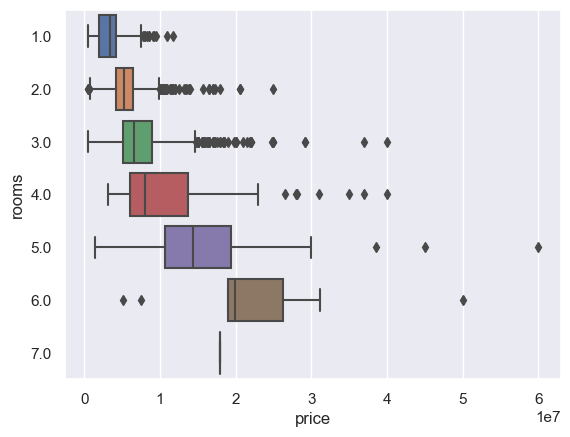

In [193]:
#Исследование рынка жилой недвижимости в Томске

#Гипотеза 1: Количество комнат влияет на цену недвижимости

sns.boxplot(data=dataset,
           x='price',
           y='rooms',
           orient='h')

In [194]:
#Отмечается тренд: чем больше комнат, тем выше цена на недвижимость. Причем увеличивается интерквартильный размах в цене.
#Но необходимо понимать, что скорее первопричиной увеличения стоимоти является увеличение размера площади квартиры
# (и как следствие увеличение числа комнат).

<Axes: xlabel='full_area', ylabel='price'>

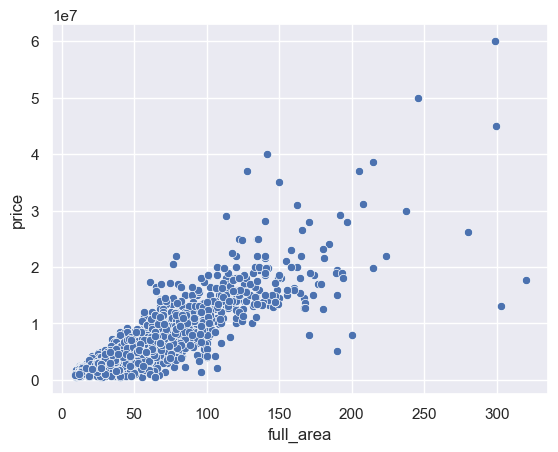

In [195]:
sns.scatterplot(x=dataset.full_area, y=dataset.price)

In [196]:
#Легко определяется линейная зависимость между ценой и площадью недвижимости.

<Axes: xlabel='count', ylabel='material_type'>

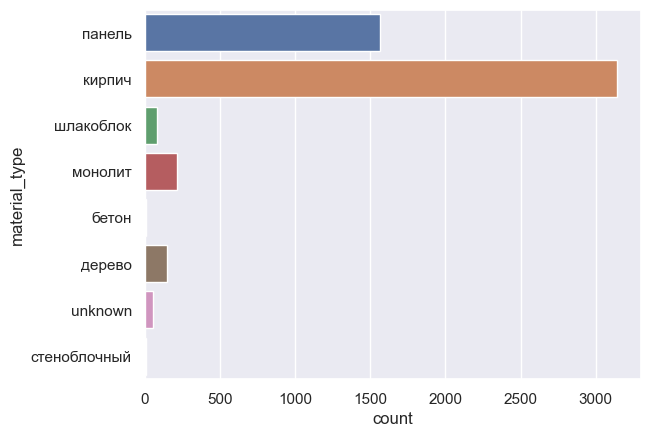

In [197]:
#Определим наиболее популярные материалы, используемые при строительстве
sns.countplot(
    data=dataset,
    y='material_type')

In [198]:
#На рынке преобладают объекты недвижимости, построенные из кирпича или плит (стеновых панелей).

<Axes: xlabel='count', ylabel='flat_type'>

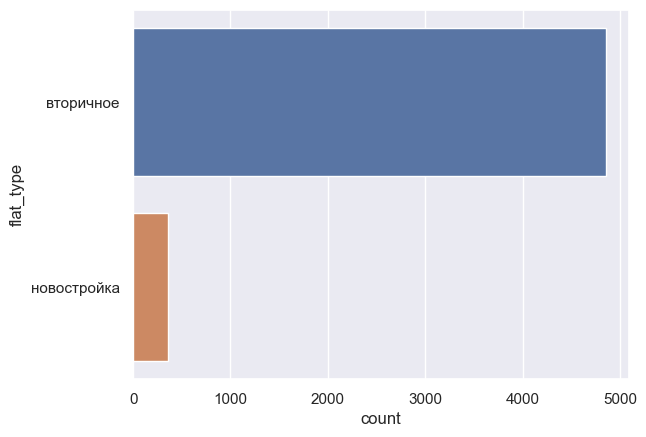

In [199]:
#Посмотрим, преобладают новостройки или вторичное жилье

sns.countplot(
dataset,
y='flat_type')

In [200]:
print('Доли первичного и вторичного жилья на рынке недвижимости Томска составляют соответственно: '
      f"{round(dataset[dataset['flat_type']=='новостройка'].count().values[0]/dataset.shape[0]*100)}% / {round(dataset[dataset['flat_type']=='вторичное'].count().values[0]/dataset.shape[0]*100)}%")

Доли первичного и вторичного жилья на рынке недвижимости Томска составляют соответственно: 7% / 93%


<Axes: >

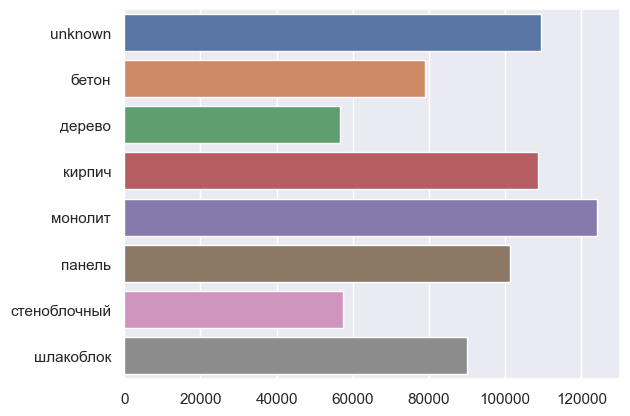

In [201]:
#Определим зависимости между материалом и ценой за квадратный метр

sns.barplot(
x=dataset.sort_values(by='material_type').groupby('material_type')['price_square_metr'].agg('median').values,
y=dataset.sort_values(by='material_type').material_type.unique(), 
)

In [202]:
#Наиболее высокая цена за квадратный метр отмечается в квартирах, построенных из монолита, кирпича, бетонных плит.

<Axes: xlabel='full_area', ylabel='price_square_metr'>

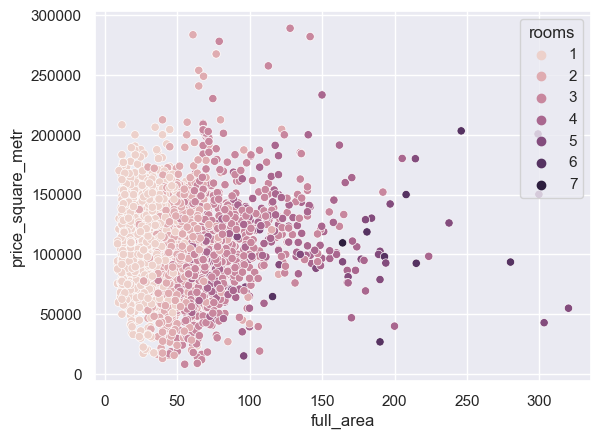

In [203]:
#Исследуем цену за квадратный метр в зависимости от площади
sns.scatterplot(
data=dataset,
x='full_area',
y='price_square_metr',
hue='rooms')

In [204]:
#Чем меньше площадь квартиры и меньше комнат, тем больше прайс за квадратный метр жилья.

<Axes: xlabel='count', ylabel='rooms'>

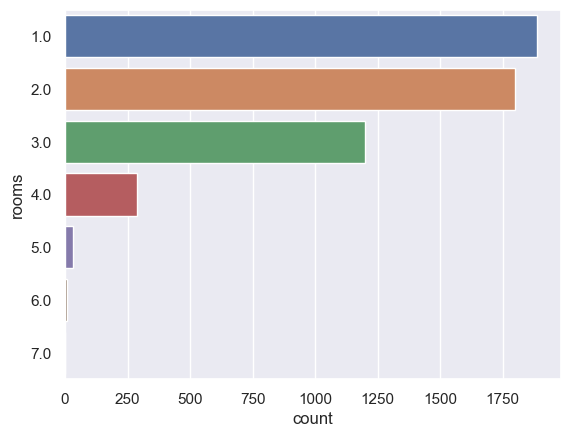

In [205]:
#Объем квартир на рынке по числу комнат

sns.countplot(
dataset,
y='rooms')

<Axes: >

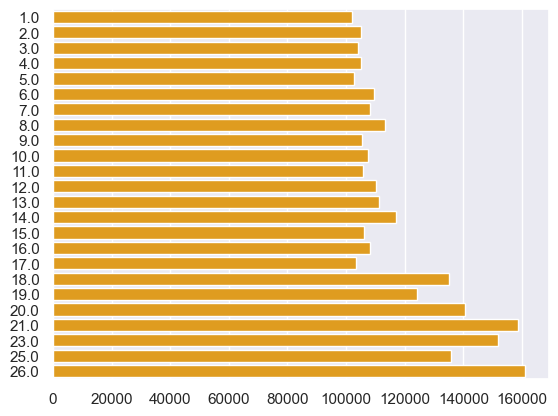

In [206]:
#Посмотрим, влияет ли этаж на стоимость жилья. При этом исключим дома из дерева и стеноблока. Также ограничим площадь до 100кв.м.

research_dataset = dataset[(dataset['material_type']!='дерево')&(dataset['material_type']!='шлакоблок')&(dataset['material_type']!='стеноблочный')&(dataset['full_area']<100)]
sns.barplot(
x=research_dataset.sort_values(by='floor_number').groupby('floor_number')['price_square_metr'].agg('median').values,
y=research_dataset.sort_values(by='floor_number').floor_number.unique(),
orient='h',
color='orange'
)

In [207]:
#Можно с уверенностью сказать, что этаж практически не влияет на стоимость квадратного метра жилья.
#Характерная ступенька (с 18го этажа) связана с тем, что в Томске преобладающее больгинство зданий ограничено 17ю этажами.
#Есть лишь 2 ЖК с этажностью более 17 этажей.

In [17]:
#Преобразуем категориальные признаки в численные для составления прогнозной модели

transformer = make_column_transformer(
(OneHotEncoder(), ['repair_type', 'bathroom_type', 'material_type', 'flat_type', 'balcony_type']), remainder = 'passthrough', verbose_feature_names_out=False)

transformed = transformer.fit_transform(dataset)
dataset_final = pd.DataFrame(transformed, columns = transformer.get_feature_names_out())
dataset_final

,repair_type_unknown,repair_type_в отличном состоянии,repair_type_в хорошем состоянии,repair_type_требуется ремонт,repair_type_черновая отделка,bathroom_type_unknown,bathroom_type_раздельный,bathroom_type_совмещенный,material_type_unknown,material_type_бетон,material_type_дерево,material_type_кирпич,material_type_монолит,material_type_панель,material_type_стеноблочный,material_type_шлакоблок,flat_type_вторичное,flat_type_новостройка,balcony_type_2 балкона,"balcony_type_2 балкона, остекление",balcony_type_2 лоджии,"balcony_type_2 лоджии, остекление",balcony_type_unknown,balcony_type_балкон,balcony_type_балкон и лоджия,"balcony_type_балкон и лоджия, остекление","balcony_type_балкон, остекление",balcony_type_лоджия,"balcony_type_лоджия, остекление",price,rooms,full_area,living_area,kitchen_area,floor_number,floors_in_building
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3300000.0,1.0,30.0,18.000000,6.000000,3.0,5.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8500000.0,2.0,58.7,49.940000,11.261538,6.0,19.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2000000.0,1.0,13.0,11.500000,4.000000,1.0,5.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8100000.0,2.0,63.5,31.800000,9.400000,3.0,10.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6600000.0,2.0,60.0,35.000000,25.000000,6.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5208,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2100000.0,2.0,27.0,24.000000,6.729942,6.0,9.0
5209,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1600000.0,2.0,37.7,25.375146,5.000000,5.0,5.0
5210,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,570000.0,3.0,64.0,43.216667,14.000000,1.0,1.0
5211,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4850000.0,3.0,58.0,41.000000,5.000000,5.0,5.0


In [18]:
dataset_final.corr()

,repair_type_unknown,repair_type_в отличном состоянии,repair_type_в хорошем состоянии,repair_type_требуется ремонт,repair_type_черновая отделка,bathroom_type_unknown,bathroom_type_раздельный,bathroom_type_совмещенный,material_type_unknown,material_type_бетон,material_type_дерево,material_type_кирпич,material_type_монолит,material_type_панель,material_type_стеноблочный,material_type_шлакоблок,flat_type_вторичное,flat_type_новостройка,balcony_type_2 балкона,"balcony_type_2 балкона, остекление",balcony_type_2 лоджии,"balcony_type_2 лоджии, остекление",balcony_type_unknown,balcony_type_балкон,balcony_type_балкон и лоджия,"balcony_type_балкон и лоджия, остекление","balcony_type_балкон, остекление",balcony_type_лоджия,"balcony_type_лоджия, остекление",price,rooms,full_area,living_area,kitchen_area,floor_number,floors_in_building
repair_type_unknown,1.000000,-0.192768,-0.315441,-0.110442,-0.090785,0.428634,-0.149102,-0.098532,-0.002600,-0.009155,0.013322,0.030946,-0.006988,-0.031931,-0.010237,-0.004081,-0.123373,0.123373,0.013177,-0.027959,-0.012483,-0.044615,0.225995,-0.065825,-0.017748,-0.026588,-0.048332,-0.028143,-0.092767,-0.014268,-0.000257,-0.009966,0.009266,-0.035347,0.028582,0.005562
repair_type_в отличном состоянии,-0.192768,1.000000,-0.557100,-0.195052,-0.160335,-0.100226,-0.003765,0.062073,-0.030059,0.031577,-0.062592,0.048853,-0.005775,-0.018968,0.024631,-0.018269,0.136322,-0.136322,0.002480,0.009989,0.029486,0.078746,-0.076568,-0.084360,-0.014889,0.010279,0.017001,0.026490,0.093085,0.226701,0.044886,0.106327,0.099128,0.096043,0.071027,0.076468
repair_type_в хорошем состоянии,-0.315441,-0.557100,1.000000,-0.319178,-0.262369,-0.175056,0.092754,0.008048,-0.015896,-0.026458,0.037973,-0.079137,-0.089869,0.113272,-0.017177,0.010457,0.226724,-0.226724,0.003277,-0.007462,-0.044522,-0.080913,-0.038998,0.162242,0.027582,0.013557,0.005679,-0.047696,-0.051360,-0.181325,-0.089508,-0.137575,-0.138426,-0.123556,-0.066305,-0.083720
repair_type_требуется ремонт,-0.110442,-0.195052,-0.319178,1.000000,-0.091861,-0.012527,0.028082,-0.021093,0.002944,-0.009264,0.050409,-0.081020,0.126368,0.001380,0.010251,0.042085,-0.082562,0.082562,-0.014612,-0.008690,0.016289,0.007032,0.019155,-0.041643,0.005863,-0.011941,0.027352,0.004253,-0.006805,-0.052536,0.093376,0.018499,0.021544,-0.011634,-0.054251,-0.087852
repair_type_черновая отделка,-0.090785,-0.160335,-0.262369,-0.091861,1.000000,0.027997,-0.034131,0.018211,0.081849,0.019500,-0.042452,0.130745,0.044949,-0.153514,-0.008514,-0.034087,-0.434468,0.434468,-0.008797,0.040392,0.032184,0.067754,-0.079331,-0.047690,-0.014762,0.001036,-0.015908,0.075913,0.057972,0.046704,-0.011087,0.077641,0.065565,0.132809,0.039137,0.130292
bathroom_type_unknown,0.428634,-0.100226,-0.175056,-0.012527,0.027997,1.000000,-0.305582,-0.272590,-0.000006,-0.008764,0.066458,0.038237,-0.015264,-0.058299,-0.009799,0.004461,-0.161221,0.161221,-0.003448,-0.009951,-0.003923,-0.037652,0.310839,-0.115137,-0.016989,-0.029567,-0.085530,-0.046962,-0.103504,0.024596,-0.009353,0.010737,0.037125,0.008863,0.026304,0.005153
bathroom_type_раздельный,-0.149102,-0.003765,0.092754,0.028082,-0.034131,-0.305582,1.000000,-0.832809,-0.028388,0.014816,-0.063467,-0.053755,0.008091,0.094540,-0.017537,-0.041301,0.098137,-0.098137,0.040578,0.059914,0.053346,0.053912,-0.309362,0.248221,0.034096,0.097908,-0.021820,0.015249,0.016430,0.211372,0.379566,0.313944,0.284447,0.169120,0.082223,0.126461
bathroom_type_совмещенный,-0.098532,0.062073,0.008048,-0.021093,0.018211,-0.272590,-0.832809,1.000000,0.028689,-0.009876,0.025495,0.032088,0.000698,-0.061636,0.023418,0.039140,-0.005435,0.005435,-0.038997,-0.054756,-0.051623,-0.032587,0.131887,-0.183882,-0.024576,-0.081743,0.071773,0.011894,0.043572,-0.227883,-0.378101,-0.323472,-0.309007,-0.176042,-0.098376,-0.130780
material_type_unknown,-0.002600,-0.030059,-0.015896,0.002944,0.081849,-0.000006,-0.028388,0.028689,1.000000,-0.002861,-0.017652,-0.127343,-0.021417,-0.067542,-0.003200,-0.012809,-0.060732,0.060732,0.019

In [19]:
model = LinearRegression()
y = dataset_final['price']
x = dataset_final.drop(columns='price', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
model.fit(x_train, y_train)
prediction_price = model.predict(x_test)

In [20]:
print(r2_score(y_test, prediction_price), mean_absolute_error(y_test, prediction_price))


0.7506312714799475 1022136.2913831405


In [222]:
x = dataset_final['full_area'].values.reshape(-1,1)
scaler.fit(x)
full_area_norm = scaler.transform(x)
dataset_final['full_area_norm'] = full_area_norm
dataset_final = dataset_final.drop(columns='full_area', axis=1)

In [223]:
x = dataset_final['living_area'].values.reshape(-1,1)
scaler.fit(x)
living_area_norm = scaler.transform(x)
dataset_final['living_area_norm'] = living_area_norm
dataset_final = dataset_final.drop(columns='living_area', axis=1)

In [224]:
x = dataset_final['kitchen_area'].values.reshape(-1,1)
scaler.fit(x)
kitchen_area_norm = scaler.transform(x)
dataset_final['living_area_norm'] = kitchen_area_norm
dataset_final = dataset_final.drop(columns='kitchen_area', axis=1)

In [225]:
model = LinearRegression()
y = dataset_final['price']
x = dataset_final.drop(columns='price', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
model.fit(x_train, y_train)
prediction_price = model.predict(x_test)

In [226]:
print(r2_score(y_test, prediction_price), mean_absolute_error(y_test, prediction_price))

0.7513478794170265 1025945.9840153452
